In [0]:
%sql
SELECT GETDATE() as last_run;

last_run
2022-10-21T15:26:24.304+0000


### Objective: Forecasting ML ARIMA models - predict multiple COVID-19 stats 45 days in the future from weekly updated CDC dataset

#### Public CDC dataset: United States COVID-19 Cases and Deaths by State over Time
Source: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36 <br>
As of October 20, 2022, the CDC dataset is updated weekly on Thursdays, typically by 8 PM ET. This notebook is updated on a weekly basis on Fridays, 7 AM ET.

#### Download data from URL

In [0]:
%scala
import org.apache.commons.io.IOUtils
import java.net.URL 

val urlfile=new URL("https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD")
val covid_cases_and_deaths_csv = IOUtils.toString(urlfile,"UTF-8").lines.toList.toDS()
val covid_cases_and_deaths_orig = spark
                .read.option("header", true)
                .option("inferSchema", true)
                .csv(covid_cases_and_deaths_csv)

import org.apache.commons.io.IOUtils
import java.net.URL
urlfile: java.net.URL = https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD
covid_cases_and_deaths_csv: org.apache.spark.sql.Dataset[String] = [value: string]
covid_cases_and_deaths_orig: org.apache.spark.sql.DataFrame = [submission_date: string, state: string ... 13 more fields]

#### Transform submission_date and created_at to date and timestamp format

In [0]:
%scala
import org.apache.spark.sql.functions._
import spark.sqlContext.implicits._

covid_cases_and_deaths_orig.count()

import org.apache.spark.sql.functions._
import spark.sqlContext.implicits._
res1: Long = 60060

In [0]:
%scala

val covid_cases_and_deaths_transformed = covid_cases_and_deaths_orig
        .withColumn("submission_date_as_date", to_date(col("submission_date"), "MM/dd/yyyy"))
        .withColumn("created_at_timestamp", to_timestamp(col("created_at"), "MM/dd/yyyy hh:mm:ss a"))
        .drop("submission_date", "created_at")
        .withColumnRenamed("submission_date_as_date", "submission_date")
        .select("*")

display(covid_cases_and_deaths_transformed.select("state", "submission_date", "created_at_timestamp", "tot_cases", "new_case", "pnew_case", "new_death", "pnew_death").orderBy(desc("submission_date")))

state,submission_date,created_at_timestamp,tot_cases,new_case,pnew_case,new_death,pnew_death
FL,2022-10-18,2022-10-18T00:00:00.000+0000,7145833,1661,660,0,0
MI,2022-10-18,2022-10-19T13:15:24.000+0000,2874009,12414,2828,173,37
NJ,2022-10-18,2022-10-19T13:15:24.000+0000,2773961,1944,544,10,0
MN,2022-10-18,2022-10-19T13:15:24.000+0000,1676151,0,0,0,0
NY,2022-10-18,2022-10-19T13:15:24.000+0000,3275131,1660,0,32,0
OR,2022-10-18,2022-10-19T13:15:24.000+0000,902319,0,0,0,0
HI,2022-10-18,2022-10-19T13:15:24.000+0000,349598,0,0,0,0
WV,2022-10-18,2022-10-19T13:15:24.000+0000,605012,224,86,3,1
OK,2022-10-18,2022-10-19T13:15:24.000+0000,1205519,0,0,0,0
PR,2022-10-18,2022-10-19T13:15:24.000+0000,969066,159,117,5,2


In [0]:
%scala

covid_cases_and_deaths_transformed.printSchema()

root
-- state: string (nullable = true)
-- tot_cases: integer (nullable = true)
-- conf_cases: integer (nullable = true)
-- prob_cases: integer (nullable = true)
-- new_case: integer (nullable = true)
-- pnew_case: integer (nullable = true)
-- tot_death: integer (nullable = true)
-- conf_death: integer (nullable = true)
-- prob_death: integer (nullable = true)
-- new_death: integer (nullable = true)
-- pnew_death: integer (nullable = true)
-- consent_cases: string (nullable = true)
-- consent_deaths: string (nullable = true)
-- submission_date: date (nullable = true)
-- created_at_timestamp: timestamp (nullable = true)

In [0]:
%scala

covid_cases_and_deaths_transformed.head(n=5)

res5: Array[org.apache.spark.sql.Row] = Array([KS,297229,241035,56194,0,0,4851,null,null,0,0,Agree,N/A,2021-03-11,2021-03-12 15:20:13.0], [ND,163565,135705,27860,589,220,1907,null,null,9,0,Agree,Not agree,2021-12-01,2021-12-02 14:35:20.0], [AS,11,null,null,0,0,0,null,null,0,0,null,null,2022-01-02,2022-01-03 15:18:16.0], [AL,841461,620483,220978,703,357,16377,12727,3650,7,3,Agree,Agree,2021-11-22,2021-11-22 00:00:00.0], [AK,251425,null,null,0,0,1252,null,null,0,0,N/A,N/A,2022-05-30,2022-05-31 13:20:20.0])

#### See the latest 100 additions to source dataset, note that submission_date and created_at_timestamp aren't always close to one another

In [0]:
%scala

display(covid_cases_and_deaths_transformed.orderBy("created_at_timestamp")
        .select("state", "submission_date", "created_at_timestamp", "tot_cases", "new_case", "pnew_case", "new_death", "pnew_death")
        .tail(n=100))

state,submission_date,created_at_timestamp,tot_cases,new_case,pnew_case,new_death,pnew_death
WY,2022-10-17,2022-10-18T13:16:07.000+0000,177635,0,0,0,0
NV,2022-10-17,2022-10-18T13:16:07.000+0000,850204,144,26,1,0
FSM,2022-10-17,2022-10-18T13:16:07.000+0000,21815,0,0,0,0
VT,2022-10-17,2022-10-18T13:16:07.000+0000,133661,203,25,0,0
LA,2022-10-17,2022-10-18T13:16:07.000+0000,1459308,0,0,0,0
WA,2022-10-17,2022-10-18T13:16:07.000+0000,1828906,1275,137,14,0
RMI,2022-10-17,2022-10-18T13:16:07.000+0000,15389,14,0,0,0
IN,2022-10-17,2022-10-18T13:16:07.000+0000,1930022,0,0,0,0
AK,2022-10-17,2022-10-18T13:16:07.000+0000,284076,0,0,0,0
CO,2022-10-17,2022-10-18T13:16:07.000+0000,1664672,1359,107,5,0


#### Oddly, there are some negative values for "new_case", "new_death", etc. which has implications for some of the plots later on that also display negative values...

In [0]:
%scala

display(covid_cases_and_deaths_transformed.orderBy("created_at_timestamp")
        .select("state", "submission_date", "created_at_timestamp", "tot_cases", "new_case", "pnew_case", "new_death", "pnew_death")
        .where("new_case < 0 and new_death < 0"))

state,submission_date,created_at_timestamp,tot_cases,new_case,pnew_case,new_death,pnew_death
CA,2020-03-30,2020-04-01T00:00:00.000+0000,5763,-4803,0,-100,0
CA,2020-05-13,2020-05-15T00:00:00.000+0000,65981,-3401,0,-96,0
ND,2021-02-08,2021-02-09T15:24:29.000+0000,98175,-9,53,-1,0
VI,2021-03-24,2021-03-25T14:25:23.000+0000,2876,-1,0,-1,0


#### Create training and holdout datasets

In [0]:
%scala

// Training = everything that's older than 3 days according to created_at_timestamp

val training = covid_cases_and_deaths_transformed.filter("to_date(created_at_timestamp) < date_sub(to_date(current_timestamp()), 3)")

training.count()

training: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [state: string, tot_cases: int ... 13 more fields]
res8: Long = 59923

In [0]:
%scala

// Holdout = everything that's newer than 3 days according to created_at_timestamp

val holdout = covid_cases_and_deaths_transformed.filter("to_date(created_at_timestamp) > date_sub(to_date(current_timestamp()), 3)")

holdout.count()

holdout: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [state: string, tot_cases: int ... 13 more fields]
res10: Long = 69

#### Write tables to Databricks DB

In [0]:
%scala

covid_cases_and_deaths_transformed.write.mode("overwrite").format("parquet").saveAsTable("edavdemo.covid_cases_and_deaths_all")
training.write.mode("overwrite").format("parquet").saveAsTable("edavdemo.covid_cases_and_deaths_training")
holdout.write.mode("overwrite").format("parquet").saveAsTable("edavdemo.covid_cases_and_deaths_holdout")

In [0]:
%scala

display(holdout.select("created_at_timestamp", "submission_date", "state", "new_case", "new_death"))

created_at_timestamp,submission_date,state,new_case,new_death
2022-10-19T13:15:24.000+0000,2022-10-18,IA,844,27
2022-10-19T13:15:24.000+0000,2022-10-18,NY,1660,32
2022-10-19T13:15:24.000+0000,2022-10-18,NM,266,0
2022-10-19T12:33:33.000+0000,2020-04-23,FL,1213,49
2022-10-19T13:15:24.000+0000,2022-10-18,MP,0,0
2022-10-19T13:15:24.000+0000,2022-10-18,PW,0,0
2022-10-19T13:15:24.000+0000,2022-10-18,OK,0,0
2022-10-19T13:15:24.000+0000,2022-10-18,SD,0,0
2022-10-19T12:33:33.000+0000,2020-04-26,FL,508,46
2022-10-19T13:15:24.000+0000,2022-10-18,ND,0,0


## Model 1: Forecast parameter "new_case"

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "new_case"
time_col = "submission_date"
unit = "day"

horizon = 45

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Use all data for training since the last few that are in the holdout set are the most critical for better future predictions
df_loaded = spark.sql("select submission_date, new_case from hive_metastore.edavdemo.covid_cases_and_deaths_all")

# Preview data
df_loaded.head(5)

Out[3]: [Row(submission_date=datetime.date(2021, 1, 23), new_case=5152),
 Row(submission_date=datetime.date(2021, 9, 9), new_case=907),
 Row(submission_date=datetime.date(2020, 12, 7), new_case=313),
 Row(submission_date=datetime.date(2020, 9, 19), new_case=833),
 Row(submission_date=datetime.date(2021, 8, 31), new_case=1003)]

In [0]:
df_loaded.count()

Out[4]: 60060

## Train ARIMA model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/149615930442154/s?orderByKey=metrics.%60val_smape%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
# Define the search space of seasonal period m
seasonal_periods = [1, 7]

### Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .avg(target_col) \
  .withColumnRenamed(time_col, "ds") \
  .withColumnRenamed("avg(new_case)", "y")

df_aggregated = df_aggregated.toPandas()
df_loaded.toPandas()

df_aggregated.reset_index()

df_aggregated.head()

,ds,y
0,2022-03-28,548.983333
1,2021-10-11,1301.383333
2,2020-08-24,597.100000
3,2021-12-18,1489.916667
4,2021-08-27,3049.283333


In [0]:
result_columns = ["pickled_model", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  arima_estim = ArimaEstimator(horizon=horizon, frequency_unit=unit, metric="smape",
                              seasonal_periods=seasonal_periods, num_folds=20)

  results_pd = arima_estim.fit(history_pd)
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import ArimaModel, mlflow_arima_log_model

with mlflow.start_run(experiment_id="149615930442154", run_name="ARIMA") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  arima_results = arima_training(df_aggregated)
    
  # Log metrics to mlflow
  metric_names = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
  avg_metrics = arima_results[metric_names].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  pickled_model = arima_results["pickled_model"].to_list()[0]
  arima_model = ArimaModel(pickled_model, horizon, unit, df_aggregated["ds"].min(), df_aggregated["ds"].max(), time_col)

  mlflow_arima_log_model(arima_model)

In [0]:
avg_metrics

,mean_metrics
index,
val_mse,2.304623e+06
val_rmse,1.459886e+03
val_mae,8.314689e+02
val_mape,7.288683e-01
val_mdape,3.543240e-01
val_smape,5.057757e-01
val_coverage,7.564827e-01


## Analyze the predicted results

In [0]:
# Load the model
run_id =  mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/10/21 15:28:32 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:
/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:


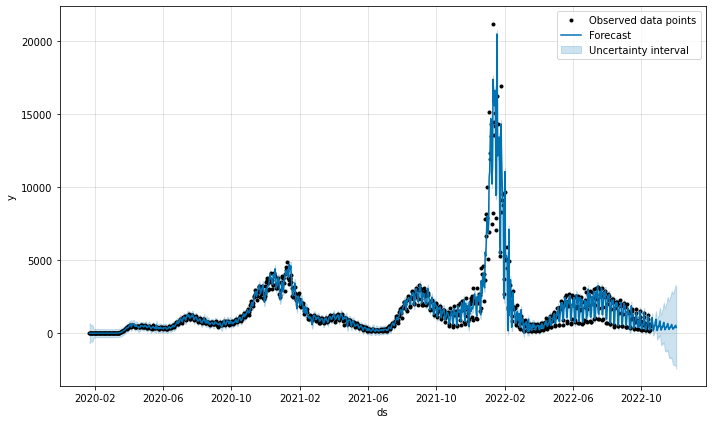

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

history_pd = df_aggregated
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model().order[1]
fig = plot(history_pd[d:], forecast_pd[d:])
fig
print()

## Predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].rename(columns={'ds': 'date', 'yhat': 'new_case'}).tail(horizon))

date,new_case
2022-10-19T00:00:00.000+0000,903.028842846624
2022-10-20T00:00:00.000+0000,1071.8147511544187
2022-10-21T00:00:00.000+0000,547.2435033422803
2022-10-22T00:00:00.000+0000,166.77223263969017
2022-10-23T00:00:00.000+0000,258.1642943549766
2022-10-24T00:00:00.000+0000,482.69548923120635
2022-10-25T00:00:00.000+0000,489.40807272422137
2022-10-26T00:00:00.000+0000,825.5381620706926
2022-10-27T00:00:00.000+0000,958.210172465383
2022-10-28T00:00:00.000+0000,489.82444623630334


## Model 2: Forecast parameter "new_death"

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "new_death"
time_col = "submission_date"
unit = "day"

horizon = 45

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Use all data for training since the last few that are in the holdout set are the most critical for better future predictions
df_loaded = spark.sql("select submission_date, new_death from hive_metastore.edavdemo.covid_cases_and_deaths_all")

# Preview data
df_loaded.head(5)

Out[15]: [Row(submission_date=datetime.date(2021, 1, 23), new_death=111),
 Row(submission_date=datetime.date(2021, 9, 9), new_death=11),
 Row(submission_date=datetime.date(2020, 12, 7), new_death=12),
 Row(submission_date=datetime.date(2020, 9, 19), new_death=6),
 Row(submission_date=datetime.date(2021, 8, 31), new_death=0)]

In [0]:
df_loaded.count()

Out[16]: 60060

### Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .avg(target_col) \
  .withColumnRenamed(time_col, "ds") \
  .withColumnRenamed("avg(new_death)", "y")

df_aggregated = df_aggregated.toPandas()
df_loaded.toPandas()

df_aggregated.reset_index()

df_aggregated.sort_values(by=['ds'], inplace=True, ascending=False)

df_aggregated.head()

,ds,y
296,2022-10-18,6.616667
592,2022-10-17,3.666667
876,2022-10-16,0.216667
330,2022-10-15,0.600000
378,2022-10-14,4.433333


In [0]:
result_columns = ["pickled_model", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  arima_estim = ArimaEstimator(horizon=horizon, frequency_unit=unit, metric="smape",
                              seasonal_periods=seasonal_periods, num_folds=20)

  results_pd = arima_estim.fit(history_pd)
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import ArimaModel, mlflow_arima_log_model

with mlflow.start_run(experiment_id="950819147087996", run_name="ARIMA") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  arima_results = arima_training(df_aggregated)
    
  # Log metrics to mlflow
  metric_names = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
  avg_metrics = arima_results[metric_names].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  pickled_model = arima_results["pickled_model"].to_list()[0]
  arima_model = ArimaModel(pickled_model, horizon, unit, df_aggregated["ds"].min(), df_aggregated["ds"].max(), time_col)

  mlflow_arima_log_model(arima_model)

In [0]:
avg_metrics

,mean_metrics
index,
val_mse,67.214500
val_rmse,7.801553
val_mae,5.037122
val_mape,0.438100
val_mdape,0.280026
val_smape,0.361534
val_coverage,0.890691


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/10/21 15:30:35 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:
/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:


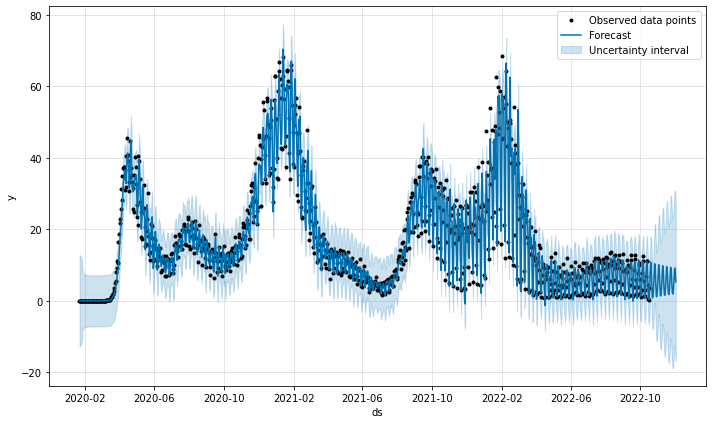

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

history_pd = df_aggregated
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model().order[1]
fig = plot(history_pd[d:], forecast_pd[d:])
fig
print()

## Predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].rename(columns={'ds': 'date', 'yhat': 'new_death'}).tail(horizon))

date,new_death
2022-10-19T00:00:00.000+0000,10.865581008572416
2022-10-20T00:00:00.000+0000,9.930335206447841
2022-10-21T00:00:00.000+0000,4.8903935464250425
2022-10-22T00:00:00.000+0000,0.8783853168342874
2022-10-23T00:00:00.000+0000,0.9965369434443218
2022-10-24T00:00:00.000+0000,3.155929746112485
2022-10-25T00:00:00.000+0000,6.793056962164528
2022-10-26T00:00:00.000+0000,10.39754811748325
2022-10-27T00:00:00.000+0000,9.804532899563334
2022-10-28T00:00:00.000+0000,4.92833492304526


## Model 3: Forecast parameter "pnew_case"

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "pnew_case"
time_col = "submission_date"
unit = "day"

horizon = 45

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Use all data for training since the last few that are in the holdout set are the most critical for better future predictions
df_loaded = spark.sql("select submission_date, pnew_case from hive_metastore.edavdemo.covid_cases_and_deaths_all")

# Preview data
df_loaded.head(5)

Out[26]: [Row(submission_date=datetime.date(2021, 1, 23), pnew_case=0),
 Row(submission_date=datetime.date(2021, 9, 9), pnew_case=0),
 Row(submission_date=datetime.date(2020, 12, 7), pnew_case=80),
 Row(submission_date=datetime.date(2020, 9, 19), pnew_case=143),
 Row(submission_date=datetime.date(2021, 8, 31), pnew_case=225)]

## Train ARIMA model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/559405260285219/s?orderByKey=metrics.%60val_smape%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

### Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .avg(target_col) \
  .withColumnRenamed(time_col, "ds") \
  .withColumnRenamed("avg(pnew_case)", "y")

df_aggregated = df_aggregated.toPandas()
df_loaded.toPandas()

df_aggregated.reset_index()

df_aggregated.sort_values(by=['ds'], inplace=True, ascending=False)

df_aggregated.head()

,ds,y
296,2022-10-18,125.883333
592,2022-10-17,106.466667
876,2022-10-16,62.533333
330,2022-10-15,39.283333
378,2022-10-14,178.316667


In [0]:
result_columns = ["pickled_model", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  arima_estim = ArimaEstimator(horizon=horizon, frequency_unit=unit, metric="smape",
                              seasonal_periods=seasonal_periods, num_folds=20)

  results_pd = arima_estim.fit(history_pd)
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import ArimaModel, mlflow_arima_log_model

with mlflow.start_run(experiment_id="559405260285219", run_name="ARIMA") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  arima_results = arima_training(df_aggregated)
    
  # Log metrics to mlflow
  metric_names = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
  avg_metrics = arima_results[metric_names].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  pickled_model = arima_results["pickled_model"].to_list()[0]
  arima_model = ArimaModel(pickled_model, horizon, unit, df_aggregated["ds"].min(), df_aggregated["ds"].max(), time_col)

  mlflow_arima_log_model(arima_model)

In [0]:
avg_metrics

,mean_metrics
index,
val_mse,186560.245655
val_rmse,417.359928
val_mae,227.714923
val_mape,0.902075
val_mdape,0.435447
val_smape,0.541895
val_coverage,0.547507


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/10/21 15:31:48 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:
/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:


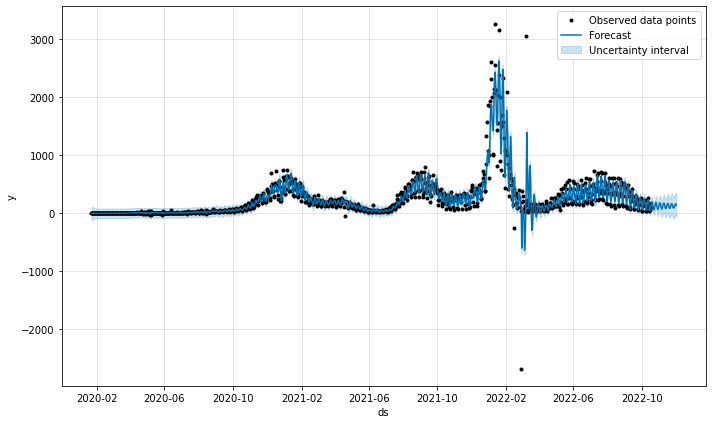

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

history_pd = df_aggregated
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model().order[1]
fig = plot(history_pd[d:], forecast_pd[d:])
fig
print()

## Predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].rename(columns={'ds': 'date', 'yhat': 'pnew_case'}).tail(horizon))

date,pnew_case
2022-10-19T00:00:00.000+0000,194.0549894221377
2022-10-20T00:00:00.000+0000,196.93588301734812
2022-10-21T00:00:00.000+0000,142.46312087953015
2022-10-22T00:00:00.000+0000,82.84366018376367
2022-10-23T00:00:00.000+0000,60.68576414782363
2022-10-24T00:00:00.000+0000,84.9309545322763
2022-10-25T00:00:00.000+0000,140.1608615474091
2022-10-26T00:00:00.000+0000,185.29839445535066
2022-10-27T00:00:00.000+0000,186.40858834623305
2022-10-28T00:00:00.000+0000,144.1230268008255


## Model 4: Forecast parameter "pnew_death"

In [0]:
target_col = "pnew_death"
time_col = "submission_date"
unit = "day"

horizon = 45

In [0]:
# Use all data for training since the last few that are in the holdout set are the most critical for better future predictions
df_loaded = spark.sql("select submission_date, pnew_death from hive_metastore.edavdemo.covid_cases_and_deaths_all")

# Preview data
df_loaded.head(5)

Out[36]: [Row(submission_date=datetime.date(2021, 1, 23), pnew_death=15),
 Row(submission_date=datetime.date(2021, 9, 9), pnew_death=0),
 Row(submission_date=datetime.date(2020, 12, 7), pnew_death=0),
 Row(submission_date=datetime.date(2020, 9, 19), pnew_death=0),
 Row(submission_date=datetime.date(2021, 8, 31), pnew_death=0)]

## Train ARIMA model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/559405260286076/s?orderByKey=metrics.%60val_smape%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
# Define the search space of seasonal period m
seasonal_periods = [1, 7]

### Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .avg(target_col) \
  .withColumnRenamed(time_col, "ds") \
  .withColumnRenamed("avg(pnew_death)", "y")

df_aggregated = df_aggregated.toPandas()
df_loaded.toPandas()

df_aggregated.reset_index()

df_aggregated.sort_values(by=['ds'], inplace=True, ascending=False)

df_aggregated.head()

,ds,y
298,2022-10-18,1.433333
595,2022-10-17,0.550000
878,2022-10-16,-0.016667
329,2022-10-15,0.033333
378,2022-10-14,0.616667


In [0]:
result_columns = ["pickled_model", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  arima_estim = ArimaEstimator(horizon=horizon, frequency_unit=unit, metric="smape",
                              seasonal_periods=seasonal_periods, num_folds=20)

  results_pd = arima_estim.fit(history_pd)
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import ArimaModel, mlflow_arima_log_model

with mlflow.start_run(experiment_id="559405260286076", run_name="ARIMA") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  arima_results = arima_training(df_aggregated)
    
  # Log metrics to mlflow
  metric_names = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
  avg_metrics = arima_results[metric_names].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  pickled_model = arima_results["pickled_model"].to_list()[0]
  arima_model = ArimaModel(pickled_model, horizon, unit, df_aggregated["ds"].min(), df_aggregated["ds"].max(), time_col)

  mlflow_arima_log_model(arima_model)

In [0]:
avg_metrics

,mean_metrics
index,
val_mse,5.088532
val_rmse,2.222443
val_mae,1.460715
val_mape,2.108270
val_mdape,0.556250
val_smape,0.742681
val_coverage,0.984209


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/10/21 15:32:02 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:
/databricks/python/lib/python3.9/site-packages/databricks/automl_runtime/forecast/pmdarima/model.py:77: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start_ds != modified_start_ds:


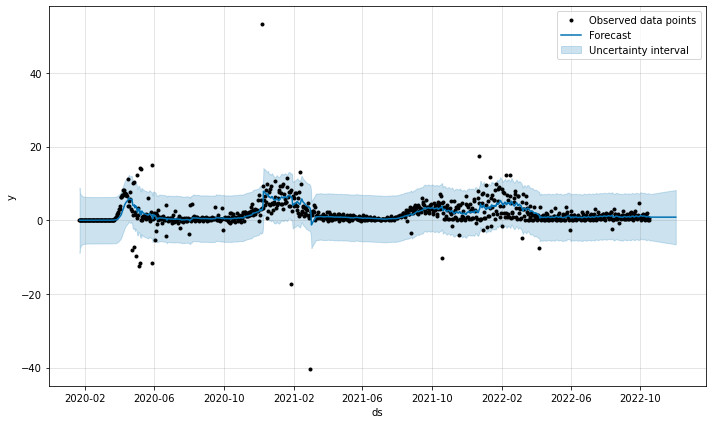

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

history_pd = df_aggregated
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model().order[1]
fig = plot(history_pd[d:], forecast_pd[d:])
fig
print()

## Predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].rename(columns={'ds': 'date', 'yhat': 'pnew_death'}).tail(horizon))

date,pnew_death
2022-10-19T00:00:00.000+0000,0.800259658214167
2022-10-20T00:00:00.000+0000,0.8516841925894393
2022-10-21T00:00:00.000+0000,0.8475069809320191
2022-10-22T00:00:00.000+0000,0.847846295569339
2022-10-23T00:00:00.000+0000,0.8478187330629252
2022-10-24T00:00:00.000+0000,0.8478209719635686
2022-10-25T00:00:00.000+0000,0.8478207900978117
2022-10-26T00:00:00.000+0000,0.8478208048707556
2022-10-27T00:00:00.000+0000,0.8478208036707503
2022-10-28T00:00:00.000+0000,0.8478208037682267
